In [7]:
import generate_data.WaveUtil as WaveUtil
import generate_data.wave2 as wave2
import generate_data.WavePostprocess as wp
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)
plt.rcParams['font.size'] = '14'

In [8]:
# set up models
import torch
import models.tiramisu as tiramisu
import models.unet as unet
import old_code.unet_Linear as unet2

#unet model setup
#unet_model = unet.UNet(wf=1, depth=3, scale_factor=2)
unet_model = unet2.UNet(depth=6, wf=1, acti_func='relu', scale_factor=2)
#unet_model = torch.nn.DataParallel(unet_model)
unet_model.load_state_dict(torch.load('../results/run_1/saved_model_unet128_9b.pt'))
unet_model.eval()
unet_model = unet_model.double()

#tiramisu model setup
tir_model = tiramisu.FCDenseNet(scale_factor=4)
tir_model = torch.nn.DataParallel(tir_model)
#tir_model = unet2.UNet(depth=6, wf=1, acti_func='relu')
tir_model.load_state_dict(torch.load('../results/run_1/saved_model_tiramisu256_1.pt'))
tir_model.eval()
tir_model = tir_model.double()

netlist = [
    (r'unet 3lvl', unet_model),
    (r'tiramisu 55-55', tir_model)
]

for netname,netmodl in netlist:
    model_parameters = filter(lambda p: p.requires_grad, netmodl.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(netname,'number of trainable parameters', params)

unet 3lvl number of trainable parameters 2560008
tiramisu 55-55 number of trainable parameters 691283


In [9]:
# parameter setup

Tf = 2.0
cT = 0.2
dx = 1.0/128.0 #1.0/128.0  # -> 256
dt = dx / 20
Ny, Nx = 256, 256
ny, nx = 64, 64
m = 4 #2
rt = 4
mt = round(Tf/cT)
t = np.linspace(0,Tf,mt)
xx, yy = np.meshgrid(np.linspace(-1, 1, Nx), np.linspace(-1, 1, Ny))

np.random.seed = 21
#center = np.array([0.,0.])
# center_1 = np.array([-.4,-.4])
# u0_1 = np.exp(-250.0*(0.2*(xx-center_1[0])**2 + (yy-center_1[1])**2))*np.cos(8*np.pi*(yy-center_1[1]))
center_2 = np.array([.4,.4])
u0_2 = np.exp(-250.0*(0.2*(xx-center_2[0])**2 + (yy-center_2[1])**2))*np.cos(8*np.pi*(yy-center_2[1]))
u0 = u0_2
# u0 = np.exp(-250.0*(0.2*(xx-center[0])**2 + (yy-center[1])**2))*np.cos(8*np.pi*(yy-center[1]))
ut0 = np.zeros([np.size(xx,axis=1),np.size(yy,axis=0)])
vel = 1. + 0.0*yy #- 0.5*(np.abs(yy+xx-0.)>0.4) + 0.*(np.abs(xx-0.4)<0.2)*(np.abs(yy-0.5)<0.1) #np.ones([np.size(xx,axis=1),np.size(yy,axis=0)]) #fig9 vel

# def four_layers(x, y):
#     res = x + np.pi / 3.1 * y
#     if res < -1:
#         return .2
#     elif res < 0:
#         return .6
#     elif res < 1:
#         return .8
#     else:
#         return 1
#
# # four layers velocity
# dim = 128
# v_x = np.linspace(-1, 1, num=dim)
# v_y = np.linspace(-1, 1, num=dim)
# z = np.array([four_layers(i, j) for j in v_y for i in v_x])
# Z = np.array(z).reshape(dim, dim)
# vel = Z

veltest = (
    #('waveguide',3. - 0.3*np.cos(np.pi*xx)),\
   #('inclusion',3.-0.5*(np.abs(xx-0.4)<0.2)*(np.abs(yy-0.5)<0.1)+0.5*(np.abs(xx-0.2)<0.2)*(np.abs(yy-0.3)<0.1) + 0.1*yy),\
   #('bp',gaussian_filter(resize(databp['V'][:,1300:3211],[128,128]),sigma=0)/1000),\
   #('marmousi',gaussian_filter(resize(datamarm['marm1smal'],[128,128]),sigma=0)/4),\
   ('refrac',vel),
    #('four layers', vel),
)

In [10]:
u0

array([[-3.48981404e-256, -1.04313107e-255, -3.09887403e-255, ...,
        -4.89514406e-221, -3.08602141e-221, -1.93357418e-221],
       [-9.35052396e-254, -2.79494035e-253, -8.30304868e-253, ...,
        -1.31159315e-218, -8.26861168e-219, -5.18077224e-219],
       [-2.31656432e-251, -6.92438104e-251, -2.05705546e-250, ...,
        -3.24943277e-216, -2.04852379e-216, -1.28352081e-216],
       ...,
       [-1.22082218e-080, -3.64912724e-080, -1.08406182e-079, ...,
        -1.71244095e-045, -1.07956566e-045, -6.76411471e-046],
       [-1.58200612e-081, -4.72873258e-081, -1.40478479e-080, ...,
        -2.21907178e-046, -1.39895843e-046, -8.76529852e-047],
       [-1.82219582e-082, -5.44667726e-082, -1.61806768e-081, ...,
        -2.55598464e-047, -1.61135672e-047, -1.00960990e-047]])

In [15]:
for velname, vel in veltest:

    #### Fine solution ####
    uf = np.zeros([xx.shape[0],xx.shape[1],mt])
    utf = np.zeros([xx.shape[0],xx.shape[1],mt])
    uf[:,:,0] = u0
    utf[:,:,0] = ut0
    for j in range(1,mt):
        uf[:,:,j],utf[:,:,j] = wave2.wave2s(uf[:,:,j-1],utf[:,:,j-1],vel,dx,dt,cT)

    # #### Coarse solution ####
    # ucc = np.zeros([xx.shape[0],xx.shape[1],mt])
    # utcc = np.zeros([xx.shape[0],xx.shape[1],mt])
    # ucc[:,:,0] = u0
    # utcc[:,:,0] = ut0
    # uc = resize(ucc[:,:,0],[ny,nx],order=4)
    # utc = resize(utcc[:,:,0],[ny,nx],order=4)
    # velc = resize(vel,[ny,nx],order=4)
    #
    # for j in range(1,mt):
    #     uc, utc = wave2.velocity_verlet_time_integrator(uc,utc,velc,dx*m,dt*rt,cT)
    #     ucc[:,:,j] = resize(uc,[xx.shape[0],xx.shape[1]],order=4)
    #     utcc[:,:,j] = resize(utc,[xx.shape[0],xx.shape[1]],order=4)
    #
    # #### UNet solution ####
    # unn1 = np.zeros([xx.shape[0],xx.shape[1],mt])
    # utnn1 = np.zeros([xx.shape[0],xx.shape[1],mt])
    # unn1[:,:,0] = u0
    # utnn1[:,:,0] = ut0
    # for j in range(1,mt):
    #     uc,utc = wave2.velocity_verlet_time_integrator(resize(unn1[:,:,j-1],[ny,nx],order=4),
    #                          resize(utnn1[:,:,j-1],[ny,nx],order=4),
    #                          resize(vel,[ny,nx],order=4),dx*m,dt*rt,cT)
    #     unn1[:,:,j],utnn1[:,:,j] = wp.ApplyJNet2WaveSol(uc,utc,vel,dx,unet_model,m)
    #
    # #### Tiramisu solution ####
    # unn2 = np.zeros([xx.shape[0],xx.shape[1],mt])
    # utnn2 = np.zeros([xx.shape[0],xx.shape[1],mt])
    # unn2[:,:,0] = u0
    # utnn2[:,:,0] = ut0
    # for j in range(1,mt):
    #     uc,utc = wave2.velocity_verlet_time_integrator(resize(unn2[:,:,j-1],[ny,nx],order=4),
    #                          resize(utnn2[:,:,j-1],[ny,nx],order=4),
    #                          resize(vel,[ny,nx],order=4),dx*m,dt*rt,cT)
    #
    #     unn2[:,:,j],utnn2[:,:,j] = wp.ApplyJNet2WaveSol(uc,utc,vel,dx,tir_model,m)

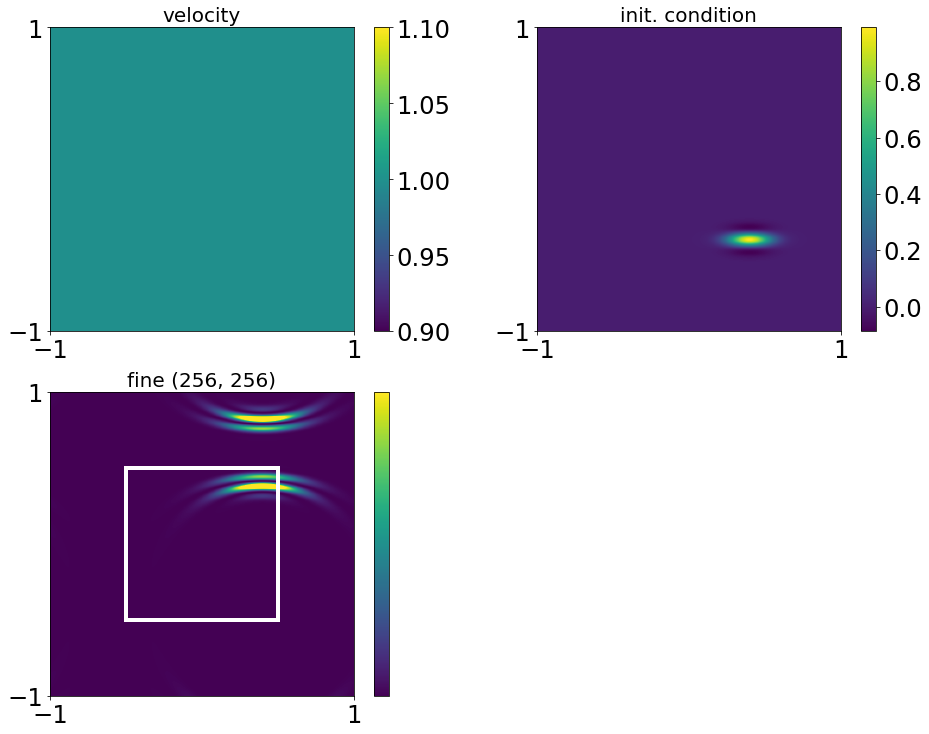

In [16]:
tj = 4
fig1 = plt.figure(figsize=(16,19))

ax1 = fig1.add_subplot(3,2,1)
pos1 = ax1.imshow(vel,extent=(-1,1,-1,1))
ax1.set_title('velocity', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.colorbar(pos1)

ax2 = fig1.add_subplot(3,2,2)
pos2 = ax2.imshow(u0,extent=(-1,1,-1,1))
ax2.set_title('init. condition', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.colorbar(pos2)

ax3 = fig1.add_subplot(3,2,3)
pos3 = ax3.imshow(WaveUtil.WaveEnergyField(uf[:,:,tj],utf[:,:,tj],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax3.set_title('fine ' + str(uf[:,:,tj].shape), fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([.5,.5],[.5,-.5],'w',linewidth=4)
plt.plot([-.5,-.5],[-.5,.5],'w',linewidth=4)
plt.plot([-.5,.5],[.5,.5],'w',linewidth=4)
plt.plot([.5,-.5],[-.5,-.5],'w',linewidth=4)
plt.colorbar(pos1,ticks = [0,0.002,0.005])

# ax4 = fig1.add_subplot(3,2,4)
# pos4 = ax4.imshow(WaveUtil.WaveEnergyField(ucc[:,:,tj],utcc[:,:,tj],vel,dx)*dx*dx,vmax=.005,extent=(-1,1,-1,1))
# ax4.set_title('coarse', fontsize=20)
# plt.xticks([-1,1])
# plt.yticks([-1,1])
# plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
# plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
# plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
# plt.colorbar(pos4,ticks = [0,0.002,0.005])
#
# ax5 = fig1.add_subplot(3,2,5)
# pos5 = ax5.imshow(WaveUtil.WaveEnergyField(unn1[:,:,tj],utnn1[:,:,tj],vel,dx)*dx*dx,vmax=.005,extent=(-1,1,-1,1))
# ax5.set_title(r'unet 6lvl $\Delta t^*=0.2 256^2$', fontsize=20)
# plt.xticks([-1,1])
# plt.yticks([-1,1])
# plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
# plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
# plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
# plt.colorbar(pos5,ticks = [0,0.002,0.005])
#
# ax6 = fig1.add_subplot(3,2,6)
# pos6 = ax6.imshow(WaveUtil.WaveEnergyField(unn2[:,:,tj],utnn2[:,:,tj],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
# ax6.set_title(r'tiramisu $\Delta t^*=0.2$ 256^2', fontsize=20)
# plt.xticks([-1,1])
# plt.yticks([-1,1])
# plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
# plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
# plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
# plt.colorbar(pos6, ticks = [0,0.002,0.005])

In [34]:
# compare wave energy norm errors:

from sklearn.metrics import mean_squared_error

for it in range(8):
    wf = WaveUtil.WaveEnergyField(uf[:,:,it], utf[:,:,it], vel, dx)*dx*dx
    w1 = WaveUtil.WaveEnergyField(unn1[:,:,it], utnn1[:,:,it], vel, dx)*dx*dx
    w2 = WaveUtil.WaveEnergyField(unn2[:,:,it], utnn2[:,:,it], vel, dx)*dx*dx

    mse1 = mean_squared_error(wf, w1)
    mse2 = mean_squared_error(wf, w2)

    print(it, mse1, mse2)

0 0.0 0.0
1 2.222971015433661e-07 8.832149092691034e-08
2 3.5725409319420366e-07 1.933508016532087e-07
3 3.45963532253423e-07 2.7905050801818685e-07
4 4.0802250862262545e-07 3.63439314263032e-07
5 4.1783613977965456e-07 3.973962301699262e-07
6 3.9512275344292934e-07 3.887815867524507e-07
7 3.65186823515949e-07 3.6404253018210757e-07


In [ ]:
'''
tiramisu128_10 outperforms unet128_9a with way less tuning parameters
training unet_128_9a and unet_128_9b is stable, and gives very similar results

tiramisu256_1 outperforms unet256_10 with way less tuning parameters, but similar training time (3x as much parameters)
'''